In [207]:
import pymodels as pm
import pyaccel as pa
import numpy as np
import matplotlib.pyplot as plt

In [208]:
plt.style.use(['notebook'])

In [209]:
# Creating a booster with small coupling
bo = pm.bo.create_accelerator(energy=3e9)
bo_famdata = pm.bo.get_family_data(bo)
bo.radiation_on = True
bo.vchamber_on = True
bo.cavity_on = True
KsL = -0.015
qs_idx = bo_famdata['QS']['index']
bo[qs_idx[0][0]].KsL = KsL

# Creating the TS line
ts, ts_init_twiss = pm.ts.create_accelerator(
                    optics_mode="M2")  # Maybe is better change to "M2"
ts.radiation_on = True
ts.vchamber_on = True

Creating the bunch

In [210]:
bo_eqparam = pa.optics.EqParamsFromBeamEnvelope(accelerator=bo)
emit1 = bo_eqparam.emit1
emit2 = bo_eqparam.emit2
sigme = bo_eqparam.espread0
sigmal = bo_eqparam.bunlen
n_part = 2000

# Supposing a emittance exchange with R=0.95
R = 0.95
deltaemit = emit1-emit2
emit1_ex = emit1 - deltaemit*R
emit2_ex = emit2 + deltaemit*R

bunch = pa.tracking.generate_bunch(n_part=n_part, emit1=emit1, emit2=emit2, 
                                   sigmae=sigme, sigmas=sigmal, optics=ts_init_twiss)
bunch_ex = pa.tracking.generate_bunch(n_part=n_part, emit1=emit1_ex, emit2=emit2_ex, 
                                   sigmae=sigme, sigmas=sigmal, optics=ts_init_twiss)

Computing emittances

In [211]:
# Shifting the bunch to the TS orbit
# centroid_at_ts =  np.array([2.73724778e-03,  4.25220469e-04, -7.24359070e-21,  3.19401356e-21,
#  -7.96083635e-05, -8.05961219e-02])

centroid_at_ts = np.array([0,0,0,0,0,0])
bunch = bunch + centroid_at_ts[:, None]
bunch_ex = bunch_ex + centroid_at_ts[:, None]

twi = ts_init_twiss
etax, etapx = twi.etax, twi.etapx
etay, etapy = twi.etay, twi.etapy
disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])

bunch_nodisp = bunch - bunch[4]*disp
bunch_ex_nodisp = bunch_ex - bunch_ex[4]*disp

emit1 = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[0:2, :])))
emit2 = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4, :])))

emit1_ex = np.sqrt(np.linalg.det(np.cov(bunch_ex_nodisp[0:2, :])))
emit2_ex = np.sqrt(np.linalg.det(np.cov(bunch_ex_nodisp[2:4, :])))

Phase diagram

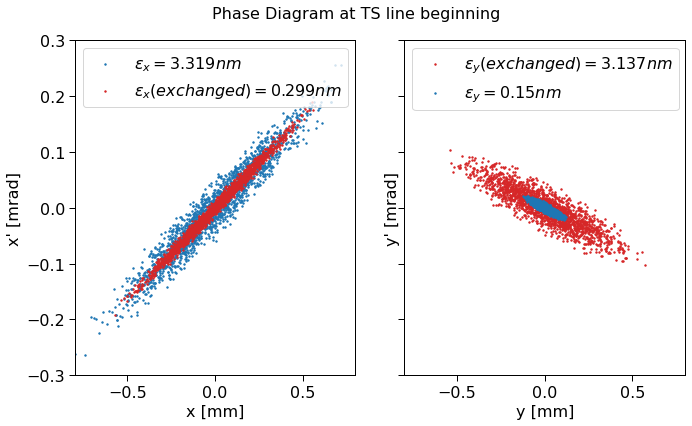

In [212]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=True, sharey=True)
x, x_ = bunch[0, :]*1e3, bunch[1, :]*1e3
y, y_ = bunch[2, :]*1e3, bunch[3, :]*1e3
x_ex, x__ex = bunch_ex[0, :]*1e3, bunch_ex[1, :]*1e3
y_ex, y__ex = bunch_ex[2, :]*1e3, bunch_ex[3, :]*1e3



ax[0].scatter(x, x_, s=2, label=r'$\epsilon_x = {:.3f} nm$'.format(emit1*1e9), alpha=1, color='tab:blue')
ax[0].scatter(x_ex, x__ex, s=2, label=r'$\epsilon_x (exchanged) = {:.3f} nm$'.format(emit1_ex*1e9), 
              color='tab:red', alpha=1)
ax[0].set_ylim([-0.30,0.30])
ax[0].set_xlim([-0.8, 0.8])

ax[1].scatter(y_ex, y__ex, s=2, label=r'$\epsilon_y (exchanged) = {:.3f} nm$'.format(emit2_ex*1e9),
              color='tab:red', alpha=1)
ax[1].scatter(y, y_, s=2, label=r'$\epsilon_y = {:.2f} nm$'.format(emit2*1e9), alpha=1, color='tab:blue')


fig.suptitle('Phase Diagram at TS line beginning', fontsize=16)
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel("x' [mrad]")
ax[1].set_xlabel('y [mm]')
ax[1].set_ylabel("y' [mrad]")
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
plt.tight_layout()
plt.savefig('before_ts.jpg',dpi=160)
plt.show()

Beam in horizontal and vertical coordinates

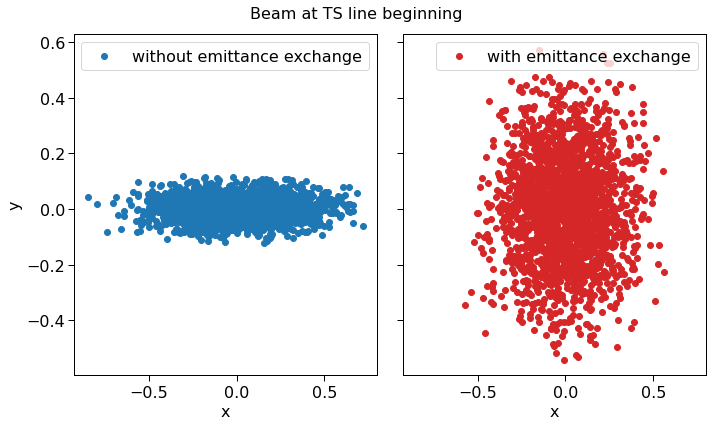

In [213]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=True, sharey=True)
fig.suptitle('Beam at TS line beginning', fontsize=16)

ax[0].scatter(x,y, label = 'without emittance exchange')
ax[1].scatter(x_ex, y_ex, color='tab:red', label='with emittance exchange')

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig("beam_size_before.jpg", dpi=160)

In [214]:
# Passing through TS
part_out, lost_flag, *_ = pa.tracking.line_pass(
            ts, bunch, indices='closed'
            )
part_out_ex, lost_flag_ex, *_ = pa.tracking.line_pass(
            ts, bunch_ex, indices='closed'
            )

In [215]:
bunch_end = part_out[:, :, -1]
bunch_ex_end = part_out_ex[:, :, -1]

Computing emittances at the end of TS line

In [216]:
# Without emittance exchange
twi, *_ = pa.optics.calc_twiss(accelerator=ts, init_twiss=ts_init_twiss)
etax, etapx = twi.etax[-1], twi.etapx[-1]
etay, etapy = twi.etay[-1], twi.etapy[-1]
disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
bunch_nodisp = bunch_end - bunch_end[4]*disp

bunch_nodisp = np.nan_to_num(bunch_nodisp) - np.nanmean(bunch_nodisp, axis=1)[:, None]
emit1 = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[0:2, :])))
emit2 = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4, :])))

# With emittance exchange
twi, *_ = pa.optics.calc_twiss(accelerator=ts, init_twiss=ts_init_twiss)
etax, etapx = twi.etax[-1], twi.etapx[-1]
etay, etapy = twi.etay[-1], twi.etapy[-1]
disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
bunch_ex_nodisp = bunch_ex_end - bunch_ex_end[4]*disp

bunch_ex_nodisp = np.nan_to_num(bunch_ex_nodisp) - np.nanmean(bunch_ex_nodisp, axis=1)[:, None]
emit1_ex = np.sqrt(np.linalg.det(np.cov(bunch_ex_nodisp[0:2, :])))
emit2_ex = np.sqrt(np.linalg.det(np.cov(bunch_ex_nodisp[2:4, :])))

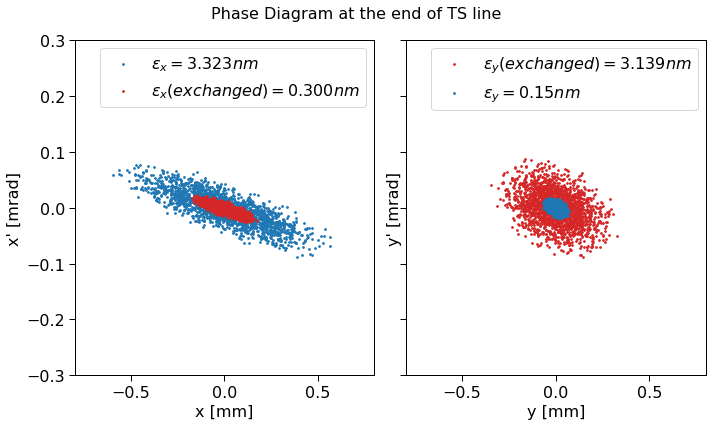

In [217]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=True, sharey=True)
x, x_ = bunch_end[0, :]*1e3, bunch_end[1, :]*1e3
y, y_ = bunch_end[2, :]*1e3, bunch_end[3, :]*1e3
x_ex, x__ex = bunch_ex_end[0, :]*1e3, bunch_ex_end[1, :]*1e3
y_ex, y__ex = bunch_ex_end[2, :]*1e3, bunch_ex_end[3, :]*1e3

ax[0].scatter(x, x_, s=3, label=r'$\epsilon_x = {:.3f} nm$'.format(emit1*1e9), alpha=1, color='tab:blue')
ax[0].scatter(x_ex, x__ex, s=3, label=r'$\epsilon_x (exchanged) = {:.3f} nm$'.format(emit1_ex*1e9), 
              color='tab:red', alpha=1)

ax[1].scatter(y_ex, y__ex, s=3, label=r'$\epsilon_y (exchanged) = {:.3f} nm$'.format(emit2_ex*1e9),
              color='tab:red', alpha=1)
ax[1].scatter(y, y_, s=3, label=r'$\epsilon_y = {:.2f} nm$'.format(emit2*1e9), alpha = 1, color='tab:blue')
ax[0].set_ylim([-0.30,0.30])
ax[0].set_xlim([-0.8, 0.8])

fig.suptitle('Phase Diagram at the end of TS line', fontsize=16)
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel("x' [mrad]")
ax[1].set_xlabel('y [mm]')
ax[1].set_ylabel("y' [mrad]")
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig('after_ts.jpg',dpi=160)
plt.show()

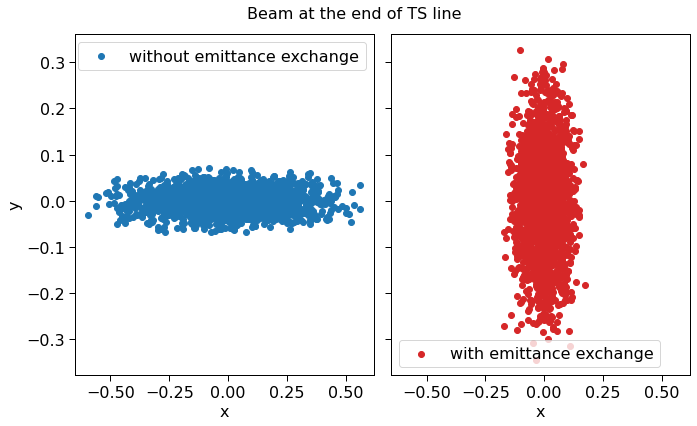

In [219]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=True, sharey=True)
fig.suptitle('Beam at the end of TS line ', fontsize=16)

ax[0].scatter(x,y, label = 'without emittance exchange')
ax[1].scatter(x_ex, y_ex, color='tab:red', label='with emittance exchange')

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig("beam_after.jpg", dpi=160)